<h1><font color='blue'> </font></h1> <h2> <center> Fake News Detection : Build a system to identify unreliable news articles </center></h2> <h3> <center> Siwar ABBES </center></h3>

## Goal :

This notebook aims to develop a machine learning program to identify when an article might be fake news (false journalism based on fallacious facts and misleading information).

## Steps :

To solve this problem we need several processing steps. 
   * First we need to convert the raw text-words into so-called **tokens** which are integer values. These tokens are really just indices into a list of the entire vocabulary. 
   * Then we convert these integer-tokens into so-called **embeddings which are real-valued vectors**, whose mapping will be trained along with the neural network, so as to map words with similar meanings to similar embedding-vectors.
   * Then we input these embedding-vectors to a **Recurrent Neural Network**
   * The output is then squashed using a **Sigmoid-function** to give us a value between 0.0 and 1.0, where 1.0 is taken to mean Fake news and 0.0 the other case.
   

## GRU (Gated Recurrent Unit)

There are many different variants of recurrent units such as the rather clunky **LSTM (Long-Short-Term-Memory)** and the somewhat simpler **GRU (Gated Recurrent Unit)** which are implemented in Keras.

LSTM ’s and GRU’s were created as the solution to short-term memory. They have internal mechanisms called gates that can regulate the flow of information.

The key difference between a GRU and an LSTM is that a GRU has two gates (reset and update gates) whereas an LSTM has three gates (namely input, output and forget gates) GRU’s has fewer tensor operations; therefore, they are a little speedier to train then LSTM


We will use the GRU in this Kontest. The GRU aims to solve the vanishing gradient problem which comes with a standard recurrent neural network.

### How GRUs work?
As mentioned above, GRUs are improved version of standard recurrent neural network. But what makes them so special and effective?
GRU has two gates :

 * A reset gate : It decides what information to throw away and what new information to add.

 * An update gate: is used to decide how much past information to forget.


In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/1042/1*jhi5uOm9PvZfmxvfaCektw.png")

In [43]:
import numpy  as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, models, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, concatenate, Dropout, GRU
from keras.utils.np_utils import to_categorical
from keras.optimizers import adam

## Reading Data

In [3]:
data = pd.read_csv("train.csv", dtype=object)
test = pd.read_csv("test.csv", dtype=object)

In [4]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [7]:
print("Train-set size: ", len(data))
print("Test-set size: ", len(test))

Train-set size:  20800
Test-set size:  5200


Combine into one data-set for some uses below.

In [8]:
X_data=data['author'].map(str)+data['title'].map(str)+data['text'].map(str)
y_data=data['label']
X_data.head()

0    Darrell LucusHouse Dem Aide: We Didn’t Even Se...
1    Daniel J. FlynnFLYNN: Hillary Clinton, Big Wom...
2    Consortiumnews.comWhy the Truth Might Get You ...
3    Jessica Purkiss15 Civilians Killed In Single U...
4    Howard PortnoyIranian woman jailed for fiction...
dtype: object

In [9]:
X_test=test['author'].map(str)+test['title'].map(str)+test['text'].map(str)

## Preprocessing


Next steps are as follows: 


    * Tokenize the text column and convert them to vector sequences 
    * Pad the sequence as needed - if the number of words in the text is greater than 'max_len' trunacate them to 'max_len' or if the number of words in the text is lesser than 'max_len' add zeros for remaining values. 
    * Split the training dataset into train and val sample. Cross validation is a time consuming process and so let us do simpletrain val split. 


### Tokenization

A neural network cannot work directly on text-strings so we must convert it somehow. There are two steps in this conversion, the first step is called the "tokenizer" **which converts words to integers** and is done on the data-set before it is input to the neural network. The second step is an integrated part of the neural network itself and is called the **"embedding"-layer**, **which is described further below.**

We may instruct the tokenizer to only use e.g. the 10000 most popular words from the data-set.

In [10]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

The tokenizer can then be "fitted" to the data-set. This scans through all the text and strips it from unwanted characters such as punctuation, and also converts it to lower-case characters. The tokenizer then builds a vocabulary of all unique words along with various data-structures for accessing the data.

In [11]:
%%time
tokenizer.fit_on_texts(X_data)

CPU times: user 33.8 s, sys: 891 ms, total: 34.7 s
Wall time: 37.1 s


We can then use the tokenizer to convert all texts in the training-set to lists of these tokens.



In [12]:
x_data_tokens = tokenizer.texts_to_sequences(X_data)

In [13]:
X_data[1]

'Daniel J. FlynnFLYNN: Hillary Clinton, Big Woman on Campus - BreitbartEver get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. 


This text corresponds to the following list of tokens:

In [14]:
np.array(x_data_tokens[1])


array([1979,  452,  111,   69,  288,  483,   10, 2071,  116,    1, 1740,
         88,  193, 5242,    1,  554,   67, 2455,    6,    5, 2201,  493,
        676,    1, 1751, 5670,  111,   69,  943,    1,  288,  483,   10,
       2071,    6,  940, 3210, 2852,  789,  873,   49,   90,  370,    2,
       5416,   49, 2131, 3361,    9,    1,    3,   49,  238,    1,  126,
       2339, 3325, 3890,    7, 3704, 3361,  951,    3,  268, 3680,  111,
         12,   74, 3466,   89,  338,   56,   48,   94, 3457,    5,  711,
          1,   68,    3,    1,  615, 2620,   98, 2648,    6, 8515,    7,
          1,  598,  839, 1631,  746,   58,  254,   15,   32,   82,   15,
          2,   33,   39, 1050,   13,    2,  450,    3,    1,   63,    1,
        273, 3926,    6,  144,    1, 1026, 2880,  114,   85,   19,    5,
        985, 5200,  286,  138,  434,  133, 5686,    7, 2339, 4578,  130,
         14,  374,    7,   54,   32,  434,  951,    9,  320,    8,   52,
          3,   79,   35,    1, 2333,    3,   79,   


We also need to convert the texts in the test-set to tokens.

In [15]:
x_test_tokens = tokenizer.texts_to_sequences(X_test)


### Padding and Truncating Data


we will use a sequence-length that covers most sequences in the data-set, and we will then truncate longer sequences and pad shorter sequences.

First we count the number of tokens in all the sequences in the data-set.

In [16]:
num_tokens = [len(tokens) for tokens in x_data_tokens]
num_tokens = np.array(num_tokens)
print('The average number of tokens in a sequence is {}'.format(np.mean(num_tokens)))
print('The maximum number of tokens in a sequence is {}'.format(np.max(num_tokens)))


The average number of tokens in a sequence is 706.8617788461538
The maximum number of tokens in a sequence is 22703



The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [17]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print('The chosen max tokens is {}'.format(max_tokens))
print('The pourcentage of entries that don''t reach the max tokens {}'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

The chosen max tokens is 2299
The pourcentage of entries that dont reach the max tokens 0.9735576923076923


This covers about 97% of the data-set.



When padding or truncating the sequences that have a different length, we need to determine if we want to do this padding or truncating 'pre' or 'post'. If a sequence is truncated, it means that a part of the sequence is simply thrown away. If a sequence is padded, it means that zeros are added to the sequence.

So the choice of 'pre' or 'post' can be important because it determines whether we throw away the first or last part of a sequence when truncating, and it determines whether we add zeros to the beginning or end of the sequence when padding. This may confuse the Recurrent Neural Network.

In [18]:
pad = 'pre'
x_data_pad = pad_sequences(x_data_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
print("We have now transformed the training-set into one big matrix of integers (tokens) with this shape:")
print(format(x_data_pad.shape))

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:
(20800, 2299)


The matrix for the test-set has the same shape:

In [19]:
x_test_pad.shape


(5200, 2299)

## Tokenizer Inverse Map


For some strange reason, the Keras implementation of a tokenizer does not seem to have the inverse mapping from integer-tokens back to words, which is needed to reconstruct text-strings from lists of tokens. So we make that mapping here.



In [20]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

Helper-function for converting a list of tokens back to a string of words.



In [21]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

# Create the Recurrent Neural Network

In [22]:
X_data_train, X_data_test, Y_data_train, Y_data_test = train_test_split(x_data_pad,y_data, test_size = 0.10, random_state = 42)
print(X_data_train.shape,Y_data_train.shape)
print(X_data_test.shape,Y_data_test.shape)

(18720, 2299) (18720,)
(2080, 2299) (2080,)


We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. 

In [23]:
model = Sequential()


The first layer in the RNN is a so-called **Embedding-layer which converts each integer-token into a vector of values.** This is necessary because the integer-tokens may take on values between 0 and 10000 for a vocabulary of 10000 words. The RNN cannot work on values in such a wide range. The embedding-layer is trained as a part of the RNN and will learn to map words with similar semantic meanings to similar embedding-vectors, as will be shown further below.

First we define the size of the embedding-vector for each integer-token. In this case we have set it to 8, so that each integer-token will be converted to a vector of length 50. The values of the embedding-vector will generally fall roughly between -1.0 and 1.0, although they may exceed these values somewhat

In [24]:
embedding_size = 50


The embedding-layer also needs to know the number of words in the vocabulary (num_words) and the length of the padded token-sequences (max_tokens). We also give this layer a name because we need to retrieve its weights further below.



In [25]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

Instructions for updating:
Colocations handled automatically by placer.


We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [26]:
model.add(GRU(units=16, return_sequences=True))


In [27]:
model.add(GRU(units=8, return_sequences=True))



This adds the second GRU with 8 output units. This will be followed by another GRU so it must also return sequences.

In [28]:
model.add(GRU(units=4))


This adds the third and final GRU with 4 output units. This will be followed by a dense-layer, so it should only give the final output of the GRU and not a whole sequence of outputs


Add a fully-connected / dense layer which computes a value between 0.0 and 1.0 that will be used as the classification output.



In [29]:
model.add(Dense(1, activation='sigmoid'))


Use the Adam optimizer with the given learning-rate.



In [30]:
optimizer = adam(lr=1e-3)

Compile the Keras model so it is ready for training.



In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [32]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 2299, 50)          500000    
_________________________________________________________________
gru_1 (GRU)                  (None, 2299, 16)          3216      
_________________________________________________________________
gru_2 (GRU)                  (None, 2299, 8)           600       
_________________________________________________________________
gru_3 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 503,977
Trainable params: 503,977
Non-trainable params: 0
_________________________________________________________________


## Train the Recurrent Neural Network


We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.



In [34]:
%%time

history=model.fit(X_data_train, Y_data_train,
          validation_split=0.05, epochs=3, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Train on 17784 samples, validate on 936 samples
Epoch 1/3
17784/17784 [==============================] - 2304s 130ms/step - loss: 0.3563 - acc: 0.8485 - val_loss: 0.2268 - val_acc: 0.9263
Epoch 2/3
17784/17784 [==============================] - 1822s 102ms/step - loss: 0.1667 - acc: 0.9477 - val_loss: 0.1918 - val_acc: 0.9316
Epoch 3/3
17784/17784 [==============================] - 1593s 90ms/step - loss: 0.1650 - acc: 0.9396 - val_loss: 0.1596 - val_acc: 0.9509
CPU times: user 1h 42min 32s, sys: 17min 2s, total: 1h 59min 34s
Wall time: 1h 35min 24s


## Performance on Test-Set


In [35]:

%%time
result = model.evaluate(X_data_test, Y_data_test)

2080/2080 [==============================] - 47s 23ms/step
CPU times: user 56 s, sys: 5.65 s, total: 1min 1s
Wall time: 46.8 s


In [36]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 94.62%


In [37]:
print('The ditribution of our label in the train data is {}'.format(Y_data_train.value_counts()))

The ditribution of our label in the train data is 1    9373
0    9347
Name: label, dtype: int64


In [38]:
print('The ditribution of our label in the train data is {}'.format(Y_data_test.value_counts()))

The ditribution of our label in the train data is 0    1040
1    1040
Name: label, dtype: int64


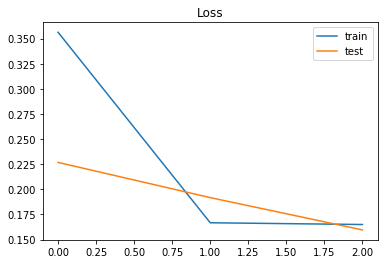

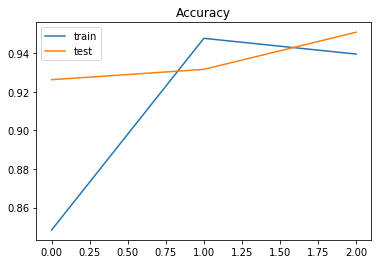

In [39]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();



In [40]:
THRESHHOLD = 0.5


predicted = pd.DataFrame(model.predict(X_data_test))
predicted[predicted<THRESHHOLD] = 0
predicted[predicted>=THRESHHOLD] = 1

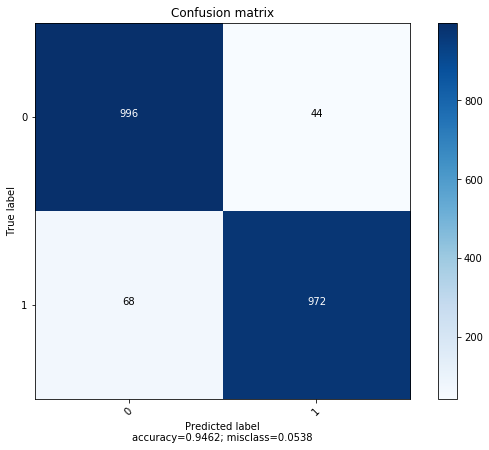

In [44]:
predicted_values = predicted[0].values
predicted_values = [int(i) for i in predicted_values]

true_values = Y_data_test.values
true_values = [int(i) for i in true_values]

labels=[0, 1]
cm = confusion_matrix(true_values, predicted_values, labels)

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import itertools
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
plot_confusion_matrix(cm,labels, normalize=False)


In [45]:
recall = cm[1, 1] / (cm[1,1] + cm[1,0])
print('The recall equals to {}'.format(recall))

The recall equals to 0.9346153846153846


In [46]:
precision = cm[1, 1] / (cm[1,1] + cm[0,1])
print('The precision equals to {}'.format(precision))

The precision equals to 0.9566929133858267


In [72]:
test_data = pd.DataFrame(x_test_pad)

print('Shape of test data tensor:', x_test_pad.shape)

test_prediction = pd.DataFrame(model.predict(x_test_pad))
test_prediction.columns = ['fake']

test_prediction[test_prediction['fake'] >= THRESHHOLD] = 1
test_prediction[test_prediction['fake'] < THRESHHOLD] = 0
test_prediction.head()

Shape of test data tensor: (5200, 2299)


,fake
0,0.0
1,1.0
2,1.0
3,0.0
4,1.0


In [78]:
test_prediction["fake"].value_counts()

0.0    2650
1.0    2550
Name: fake, dtype: int64